In [1]:
# Package Setup
import Pkg;
# Pkg.update()

# Julia Packages
using Distributions
using LinearAlgebra
using Statistics
using PGFPlots

# Satellite Dynamics Packages
using SatelliteDynamics

# Load SatelliteTasking - Reclone to keep version current
Pkg.clone("..") # For some reason this doens't work with Pkg.add + PackageSpec. Why?
using SatelliteTasking
using SatelliteTasking.SatellitePlanning
using SatelliteTasking.Analysis

# Temporary for now
Pkg.add("JuMP")
Pkg.add("Gurobi")
using JuMP
using Gurobi

┌ Warning: Pkg.clone is only kept for legacy CI script reasons, please use `add`
└ @ Pkg.API /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/API.jl:386


 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %35.8 %=============================>           ]  71.9 % Resolving package versions...
 Installed WeakRefStrings ─ v0.5.6
 Installed DataFrames ───── v0.17.1
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
  [a93c6f00] ↑ DataFrames v0.17.0 ⇒ v0.17.1
  [ea10d353] ↑ WeakRefStrings v0.5.5 ⇒ v0.5.6
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [24]:
# Figure 1 Setup - Orbit Altitude Effect on Window Duration

@time images = load_images("../data/landsat_test.json", dwell_time=5.0);

mean_duration = Tuple{Float64, Float64}[]

num_orbits = 10

@time for alt in 400:50:1000
    # Configure simulation
    epc0 = Epoch(2019, 1, 1, 0, 0, 0, tsys=:UTC) # Start of time span
    epcf = Epoch(2019, 1, 2, 0, 0, 0, tsys=:UTC) # End of simulation time span

    # Set Simulation Time Step
    timestep = 1
    dtmax    = 5

    # Define Satellite Orbit
    oe   = [R_EARTH + alt*1e3, 0, 90.0, 0, 0, 0]
    eci0 = sOSCtoCART(oe, use_degrees=true)

    # Numer of perturbed orbits to simulate

    # Set Perturbation Values 
    pos_error = 5000 # Position knowledge error [m]
    vel_error = 5    # Velocity knowledge error [m/s]
    orb_mean  = zeros(Float64, 6)
    orb_sdev  = vcat((pos_error/sqrt(3)*ones(Float64, 3))..., (vel_error/sqrt(3)*ones(Float64, 3))...)

    # Simulate true and perturbed orbits
    true_orbit, perturbed_orbits, eci_errors = simulate_orbits(num_orbits, epc0, epcf, eci0, orb_mean, orb_sdev, timestep=timestep, dtmax=dtmax);
    
    true_opportunities, perturbed_opportunities, mean_diff, sdev_diff, missing_opportunities = compute_perturbed_opportunities(true_orbit, perturbed_orbits, images, epc_step=3600);
    
    all_opportunities = sort!(vcat(perturbed_opportunities...), by = x -> x.sow)
    
    md = mean([opp.duration for opp in all_opportunities])
    
    push!(mean_duration, (alt, md))
end

  0.004677 seconds (5.91 k allocations: 354.969 KiB)


┌ Info: Simulating perturbed orbit 1
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 2
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 3
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 4
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 5
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 6
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 7
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit

┌ Info: Simulating perturbed orbit 1
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 2
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 3
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 4
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 5
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 6
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 7
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit

┌ Info: Simulating perturbed orbit 1
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 2
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 3
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 4
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 5
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 6
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 7
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit

3680.445013 seconds (36.64 G allocations: 3.002 TiB, 21.74% gc time)


In [25]:
# Figure 1 Render 
a1 = Axis([
    Plots.Linear(collect([md[1] for md in mean_duration]), collect([md[2] for md in mean_duration]))
], width="10cm", height="10cm", xmin=350, xmax=1050, ymin=0, style="ybar", 
    xlabel="Orbit Altitude [km]", ylabel="Mean Opportunity Duration [s]")

save("ijcai_figures/orbit_altitude.tex", a1, include_preamble=false)

In [51]:
# Figure 1 Setup - Effect of Estimation Errors On Opportunities

@time images = load_images("../data/landsat_test_600.json", dwell_time=5.0);

mean_duration = Tuple{Float64, Float64}[]

num_orbits = 5

# Configure simulation
epc0 = Epoch(2019, 1, 1, 0, 0, 0, tsys=:UTC) # Start of time span
epcf = Epoch(2019, 1, 2, 0, 0, 0, tsys=:UTC) # End of simulation time span

# Set Simulation Time Step
timestep = 1
dtmax    = 5

# Define Satellite Orbit
oe   = [R_EARTH + 550*1e3, 0, 90.0, 0, 0, 0]
eci0 = sOSCtoCART(oe, use_degrees=true)

# Simulate 1m Error

pos_errors = [1, 10, 100, 1000, 2500, 5000]

true_orbits_array      = Orbit[]
perturbed_orbits_array = Array{Orbit,1}[]
eci_errors_array       = Array{Float64, 2}[]

true_opportunities_array      = Array{Opportunity,1}[]
perturbed_opportunities_array = Array{Array{Opportunity,1},1}[]
mean_diff_array               = Array{Float64,2}[]
sdev_diff_array               = Array{Float64,2}[]
missing_opportunities_array   = Array{Int64, 1}[]

@time for i in 1:length(pos_errors)
    perr = pos_errors[i]
    verr = perr/1000
    println("Simulating Error set $i - $perr m, $verr m/s")
    
    orb_mean  = zeros(Float64, 6)
    orb_sdev  = vcat((perr/sqrt(3)*ones(Float64, 3))..., (verr/sqrt(3)*ones(Float64, 3))...)

    
    true_orbit_i, perturbed_orbits_i, eci_errors_i = simulate_orbits(num_orbits, epc0, epcf, eci0, orb_mean, orb_sdev, timestep=timestep, dtmax=dtmax);
    true_opportunities_i, perturbed_opportunities_i, mean_diff_i, sdev_diff_i, missing_opportunities_i = compute_perturbed_opportunities(true_orbit_i, perturbed_orbits_i, images, epc_step=3600);
    
    push!(true_orbits_array, true_orbit_i)
    push!(perturbed_orbits_array, perturbed_orbits_i)
    push!(eci_errors_array, eci_errors_i)
    
    push!(true_opportunities_array, true_opportunities_i)
    push!(perturbed_opportunities_array, perturbed_opportunities_i)
    push!(mean_diff_array, mean_diff_i)
    push!(sdev_diff_array, sdev_diff_i)
    push!(missing_opportunities_array, missing_opportunities_i)
end

  0.008604 seconds (23.73 k allocations: 1.382 MiB)
Simulating Error set 1 - 1 m, 0.001 m/s


┌ Info: Simulating perturbed orbit 1
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 2
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 3
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 4
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 5
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81


Simulating Error set 2 - 10 m, 0.01 m/s


┌ Info: Simulating perturbed orbit 1
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 2
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 3
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 4
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 5
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81


Simulating Error set 3 - 100 m, 0.1 m/s


┌ Info: Simulating perturbed orbit 1
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 2
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 3
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 4
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 5
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81


Simulating Error set 4 - 1000 m, 1.0 m/s


┌ Info: Simulating perturbed orbit 1
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 2
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 3
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 4
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 5
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81


Simulating Error set 5 - 2500 m, 2.5 m/s


┌ Info: Simulating perturbed orbit 1
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 2
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 3
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 4
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 5
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81


Simulating Error set 6 - 5000 m, 5.0 m/s


┌ Info: Simulating perturbed orbit 1
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 2
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 3
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 4
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 5
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81


2606.115956 seconds (27.42 G allocations: 2.631 TiB, 20.51% gc time)


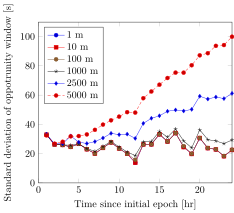

In [52]:
# Figure 2 Render - Effect of Estimation Errors On Opportunities

# a2 = Axis(collect([
#     Plots.Linear(1:24, sdev_diff_array[i][1, :], legendentry="sti - i m") for i in 1:length(pos_errors)
# ]),legendPos="north west", xmin=0, xmax=24, ymin=0, 
#     xlabel="Time since initial epoch [hr]", 
#     ylabel="Standard deviation of oppotrunity window [s]")

a2 = Axis([
    Plots.Linear(1:24, sdev_diff_array[1][1, :], legendentry="1 m")
    Plots.Linear(1:24, sdev_diff_array[2][1, :], legendentry="10 m")
    Plots.Linear(1:24, sdev_diff_array[3][1, :], legendentry="100 m")
    Plots.Linear(1:24, sdev_diff_array[4][1, :], legendentry="1000 m")
    Plots.Linear(1:24, sdev_diff_array[5][1, :], legendentry="2500 m")
    Plots.Linear(1:24, sdev_diff_array[6][1, :], legendentry="5000 m")
],legendPos="north west", xmin=0, xmax=24, ymin=0, 
    xlabel="Time since initial epoch [hr]", 
    ylabel="Standard deviation of oppotrunity window [s]")


# a2 = Axis([
#     Plots.Linear(1:24, sdev_diff_array[1][1, :], legendentry="st - 1 m")
#     Plots.Linear(1:24, sdev_diff_array[1][2, :], legendentry="et - 1 m")
#     Plots.Linear(1:24, sdev_diff_array[2][1, :], legendentry="st - 10 m")
#     Plots.Linear(1:24, sdev_diff_array[2][2, :], legendentry="et - 10 m")
#     Plots.Linear(1:24, sdev_diff_array[3][1, :], legendentry="st - 1000 m")
#     Plots.Linear(1:24, sdev_diff_array[3][2, :], legendentry="et - 5 km")
# ],legendPos="north west", xmin=0, xmax=24, ymin=0, 
#     xlabel="Time since initial epoch [hr]", 
#     ylabel="Standard deviation of oppotrunity window [s]")

save("ijcai_figures/window_difference.tex", a2, include_preamble=false)
a2

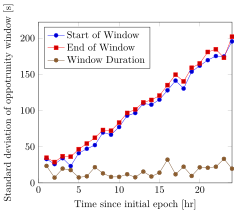

In [36]:
a3 = Axis([
    Plots.Linear(1:24, sdev_diff_5000m[1, :], legendentry="Start of Window")
    Plots.Linear(1:24, sdev_diff_5000m[2, :], legendentry="End of Window")
    Plots.Linear(1:24, sdev_diff_5000m[3, :], legendentry="Window Duration")
#     Plots.Linear(1:24, missing_opportunities_1m, legendentry="Number of Missing Opportunities")
], legendPos="north west", xmin=0, xmax=24, ymin=0, 
    xlabel="Time since initial epoch [hr]", 
    ylabel="Standard deviation of oppotrunity window [s]")
    
save("ijcai_figures/tle_window_difference.tex", a3, include_preamble=false)
a3

In [53]:
topps, popps, mdiff, sdiff, mopp = compute_perturbed_opportunities(true_orbits_array[end], [true_orbits_array[end]], images, epc_step=3600);



In [54]:
println(sdiff[1, :])
println(sdiff[2, :])
println(sdiff[3, :])

[33.1162, 26.3193, 26.0024, 24.8924, 26.8065, 23.1337, 20.1547, 24.0024, 27.9638, 23.5789, 19.9628, 13.8587, 26.4124, 26.4314, 33.4566, 28.3617, 34.4629, 24.5914, 19.8502, 30.8365, 23.8341, 22.9274, 18.3904, 22.5896]
[33.3357, 26.3532, 26.0725, 24.6661, 26.8452, 23.2219, 20.2474, 24.0752, 27.8805, 23.5151, 19.8712, 13.7327, 26.5338, 26.4326, 33.335, 28.4276, 34.5425, 24.6283, 19.7603, 30.9837, 23.9433, 22.9624, 18.3031, 22.6421]
[0.314627, 0.0936586, 0.185695, 0.226294, 0.180255, 0.139333, 0.131306, 0.182574, 0.150756, 0.16843, 0.132443, 0.125988, 0.228437, 0.177471, 0.197949, 0.134829, 0.169031, 0.163422, 0.130179, 0.210707, 0.2026, 0.232817, 0.121268, 0.105409]


In [60]:
for i in 1:length(topps)
    println("Opp Pair:")
    println(topps[i])
    println(popps[1][i])
    println(" ")
end

Opp Pair:
Opportunity(Ptr: 5151578064, Orbit: 0, Image: 4656274384, Start: Epoch(2019-01-01T00:03:45.000Z), End: Epoch(2019-01-01T00:06:57.000Z))
Opportunity(Ptr: 5152197136, Orbit: 0, Image: 4656274384, Start: Epoch(2019-01-01T00:03:45.000Z), End: Epoch(2019-01-01T00:06:57.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151701552, Orbit: 0, Image: 4659889968, Start: Epoch(2019-01-01T00:07:24.000Z), End: Epoch(2019-01-01T00:09:15.000Z))
Opportunity(Ptr: 5152303440, Orbit: 0, Image: 4659889968, Start: Epoch(2019-01-01T00:07:24.000Z), End: Epoch(2019-01-01T00:09:15.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151576704, Orbit: 0, Image: 4659781040, Start: Epoch(2019-01-01T00:07:27.000Z), End: Epoch(2019-01-01T00:09:05.000Z))
Opportunity(Ptr: 5152228304, Orbit: 0, Image: 4659781040, Start: Epoch(2019-01-01T00:07:27.000Z), End: Epoch(2019-01-01T00:09:05.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151622496, Orbit: 0, Image: 4659788240, Start: Epoch(2019-01-01T00:07:29.000Z), End: Epoch(2019-01-01T00:09:57.000Z))
Op

Opportunity(Ptr: 5151769472, Orbit: 0, Image: 4659663280, Start: Epoch(2019-01-01T00:19:37.000Z), End: Epoch(2019-01-01T00:22:12.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151767008, Orbit: 0, Image: 4659926000, Start: Epoch(2019-01-01T00:19:40.000Z), End: Epoch(2019-01-01T00:21:46.000Z))
Opportunity(Ptr: 5152385200, Orbit: 0, Image: 4659926000, Start: Epoch(2019-01-01T00:19:40.000Z), End: Epoch(2019-01-01T00:21:46.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151595408, Orbit: 0, Image: 4659784880, Start: Epoch(2019-01-01T00:20:14.000Z), End: Epoch(2019-01-01T00:21:50.000Z))
Opportunity(Ptr: 5152235744, Orbit: 0, Image: 4659784880, Start: Epoch(2019-01-01T00:20:14.000Z), End: Epoch(2019-01-01T00:21:50.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151502544, Orbit: 0, Image: 4659724144, Start: Epoch(2019-01-01T00:20:29.000Z), End: Epoch(2019-01-01T00:21:46.000Z))
Opportunity(Ptr: 5152213360, Orbit: 0, Image: 4659724144, Start: Epoch(2019-01-01T00:20:29.000Z), End: Epoch(2019-01-01T00:21:46.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5145619648, Orbit: 0, Image: 4659619024, Start: Epoch(2019-01-01T01:05:02.000Z), End: Epoch(2019-01-01T01:06:57.000Z))
Opportunity(Ptr: 5151692112, Orbit: 0, Image: 4659619024, Start: Epoch(2019-01-01T01:05:02.000Z), End: Epoch(2019-01-01T01:06:57.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151444432, Orbit: 0, Image: 4659719152, Start: Epoch(2019-01-01T01:05:05.000Z), End: Epoch(2019-01-01T01:07:32.000Z))
Opportunity(Ptr: 5151845488, Orbit: 0, Image: 4659719152, Start: Epoch(2019-01-01T01:05:05.000Z), End: Epoch(2019-01-01T01:07:32.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151295856, Orbit: 0, Image: 4659669808, Start: Epoch(2019-01-01T01:05:22.000Z), End: Epoch(2019-01-01T01:07:27.000Z))
Opportunity(Ptr: 5151806000, Orbit: 0, Image: 4659669808, Start: Epoch(2019-01-01T01:05:22.000Z), End: Epoch(2019-01-01T01:07:27.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151739744, Orbit: 0, Image: 4659893808, Start: Epoch(2019-01-01T01:05:29.000Z), End: Epoch(2019-01-01T01:06:03.000Z))


Opportunity(Ptr: 5151574464, Orbit: 0, Image: 4659611056, Start: Epoch(2019-01-01T01:09:03.000Z), End: Epoch(2019-01-01T01:10:27.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151570720, Orbit: 0, Image: 4656132976, Start: Epoch(2019-01-01T01:09:06.000Z), End: Epoch(2019-01-01T01:10:27.000Z))
Opportunity(Ptr: 5151845568, Orbit: 0, Image: 4656132976, Start: Epoch(2019-01-01T01:09:06.000Z), End: Epoch(2019-01-01T01:10:27.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151599968, Orbit: 0, Image: 4659785840, Start: Epoch(2019-01-01T01:09:19.000Z), End: Epoch(2019-01-01T01:10:49.000Z))
Opportunity(Ptr: 5152237424, Orbit: 0, Image: 4659785840, Start: Epoch(2019-01-01T01:09:19.000Z), End: Epoch(2019-01-01T01:10:49.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151692672, Orbit: 0, Image: 4659850608, Start: Epoch(2019-01-01T01:09:39.000Z), End: Epoch(2019-01-01T01:10:45.000Z))
Opportunity(Ptr: 5152294480, Orbit: 0, Image: 4659850608, Start: Epoch(2019-01-01T01:09:39.000Z), End: Epoch(2019-01-01T01:10:45.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5150416320, Orbit: 0, Image: 4659664336, Start: Epoch(2019-01-01T01:14:38.000Z), End: Epoch(2019-01-01T01:16:16.000Z))
Opportunity(Ptr: 5151777312, Orbit: 0, Image: 4659664336, Start: Epoch(2019-01-01T01:14:38.000Z), End: Epoch(2019-01-01T01:16:16.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151622576, Orbit: 0, Image: 4659551088, Start: Epoch(2019-01-01T01:14:40.000Z), End: Epoch(2019-01-01T01:17:11.000Z))
Opportunity(Ptr: 5151274928, Orbit: 0, Image: 4659551088, Start: Epoch(2019-01-01T01:14:40.000Z), End: Epoch(2019-01-01T01:17:11.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151753488, Orbit: 0, Image: 4659901008, Start: Epoch(2019-01-01T01:14:55.000Z), End: Epoch(2019-01-01T01:16:32.000Z))
Opportunity(Ptr: 5152322464, Orbit: 0, Image: 4659901008, Start: Epoch(2019-01-01T01:14:55.000Z), End: Epoch(2019-01-01T01:16:32.000Z))
 
Opp Pair:
Opportunity(Ptr: 5144910896, Orbit: 0, Image: 4659617392, Start: Epoch(2019-01-01T01:14:56.000Z), End: Epoch(2019-01-01T01:16:32.000Z))


Opportunity(Ptr: 5151812160, Orbit: 0, Image: 4655920656, Start: Epoch(2019-01-01T02:00:25.000Z), End: Epoch(2019-01-01T02:02:00.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151621616, Orbit: 0, Image: 4659549840, Start: Epoch(2019-01-01T02:00:51.000Z), End: Epoch(2019-01-01T02:03:28.000Z))
Opportunity(Ptr: 5151220416, Orbit: 0, Image: 4659549840, Start: Epoch(2019-01-01T02:00:51.000Z), End: Epoch(2019-01-01T02:03:28.000Z))
 
Opp Pair:
Opportunity(Ptr: 5149005456, Orbit: 0, Image: 4659622672, Start: Epoch(2019-01-01T02:00:58.000Z), End: Epoch(2019-01-01T02:03:09.000Z))
Opportunity(Ptr: 5151739664, Orbit: 0, Image: 4659622672, Start: Epoch(2019-01-01T02:00:58.000Z), End: Epoch(2019-01-01T02:03:09.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151504304, Orbit: 0, Image: 4655920656, Start: Epoch(2019-01-01T02:02:15.000Z), End: Epoch(2019-01-01T02:03:51.000Z))
Opportunity(Ptr: 5151812240, Orbit: 0, Image: 4655920656, Start: Epoch(2019-01-01T02:02:15.000Z), End: Epoch(2019-01-01T02:03:51.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151635296, Orbit: 0, Image: 4659610000, Start: Epoch(2019-01-01T02:41:16.000Z), End: Epoch(2019-01-01T02:43:55.000Z))
Opportunity(Ptr: 5151559600, Orbit: 0, Image: 4659610000, Start: Epoch(2019-01-01T02:41:16.000Z), End: Epoch(2019-01-01T02:43:55.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151575504, Orbit: 0, Image: 4656272656, Start: Epoch(2019-01-01T02:41:22.000Z), End: Epoch(2019-01-01T02:44:24.000Z))
Opportunity(Ptr: 5152194576, Orbit: 0, Image: 4656272656, Start: Epoch(2019-01-01T02:41:22.000Z), End: Epoch(2019-01-01T02:44:24.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151422544, Orbit: 0, Image: 4659717040, Start: Epoch(2019-01-01T02:41:31.000Z), End: Epoch(2019-01-01T02:43:09.000Z))
Opportunity(Ptr: 5151839168, Orbit: 0, Image: 4659717040, Start: Epoch(2019-01-01T02:41:31.000Z), End: Epoch(2019-01-01T02:43:09.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151172944, Orbit: 0, Image: 4659666928, Start: Epoch(2019-01-01T02:41:37.000Z), End: Epoch(2019-01-01T02:44:16.000Z))


Opportunity(Ptr: 5152317904, Orbit: 0, Image: 4659898800, Start: Epoch(2019-01-01T02:44:36.000Z), End: Epoch(2019-01-01T02:46:03.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151563600, Orbit: 0, Image: 4656129328, Start: Epoch(2019-01-01T02:44:43.000Z), End: Epoch(2019-01-01T02:45:59.000Z))
Opportunity(Ptr: 5151838448, Orbit: 0, Image: 4656129328, Start: Epoch(2019-01-01T02:44:43.000Z), End: Epoch(2019-01-01T02:45:59.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151224736, Orbit: 0, Image: 4659667600, Start: Epoch(2019-01-01T02:45:09.000Z), End: Epoch(2019-01-01T02:46:45.000Z))
Opportunity(Ptr: 5151795856, Orbit: 0, Image: 4659667600, Start: Epoch(2019-01-01T02:45:09.000Z), End: Epoch(2019-01-01T02:46:45.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151532592, Orbit: 0, Image: 4655997776, Start: Epoch(2019-01-01T02:45:17.000Z), End: Epoch(2019-01-01T02:46:16.000Z))
Opportunity(Ptr: 5151823904, Orbit: 0, Image: 4655997776, Start: Epoch(2019-01-01T02:45:17.000Z), End: Epoch(2019-01-01T02:46:16.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151740224, Orbit: 0, Image: 4659894192, Start: Epoch(2019-01-01T02:50:46.000Z), End: Epoch(2019-01-01T02:53:48.000Z))
Opportunity(Ptr: 5152309424, Orbit: 0, Image: 4659894192, Start: Epoch(2019-01-01T02:50:46.000Z), End: Epoch(2019-01-01T02:53:48.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151506064, Orbit: 0, Image: 4655921712, Start: Epoch(2019-01-01T02:50:47.000Z), End: Epoch(2019-01-01T02:53:46.000Z))
Opportunity(Ptr: 5151813920, Orbit: 0, Image: 4655921712, Start: Epoch(2019-01-01T02:50:47.000Z), End: Epoch(2019-01-01T02:53:46.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151500144, Orbit: 0, Image: 4655918832, Start: Epoch(2019-01-01T02:50:56.000Z), End: Epoch(2019-01-01T02:51:39.000Z))
Opportunity(Ptr: 5151807840, Orbit: 0, Image: 4655918832, Start: Epoch(2019-01-01T02:50:56.000Z), End: Epoch(2019-01-01T02:51:39.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151492784, Orbit: 0, Image: 4655914608, Start: Epoch(2019-01-01T02:50:58.000Z), End: Epoch(2019-01-01T02:54:22.000Z))


Opportunity(Ptr: 5152227120, Orbit: 0, Image: 4659780848, Start: Epoch(2019-01-01T04:00:45.000Z), End: Epoch(2019-01-01T04:03:57.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151603088, Orbit: 0, Image: 4659255216, Start: Epoch(2019-01-01T04:02:09.000Z), End: Epoch(2019-01-01T04:04:47.000Z))
Opportunity(Ptr: 5150423360, Orbit: 0, Image: 4659255216, Start: Epoch(2019-01-01T04:02:09.000Z), End: Epoch(2019-01-01T04:04:47.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151775232, Orbit: 0, Image: 4659931088, Start: Epoch(2019-01-01T04:16:11.000Z), End: Epoch(2019-01-01T04:18:50.000Z))
Opportunity(Ptr: 5162502112, Orbit: 0, Image: 4659931088, Start: Epoch(2019-01-01T04:16:11.000Z), End: Epoch(2019-01-01T04:18:50.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151636896, Orbit: 0, Image: 4659841200, Start: Epoch(2019-01-01T04:16:22.000Z), End: Epoch(2019-01-01T04:18:02.000Z))
Opportunity(Ptr: 5152261792, Orbit: 0, Image: 4659841200, Start: Epoch(2019-01-01T04:16:22.000Z), End: Epoch(2019-01-01T04:18:02.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151448992, Orbit: 0, Image: 4655907600, Start: Epoch(2019-01-01T04:19:31.000Z), End: Epoch(2019-01-01T04:22:06.000Z))
Opportunity(Ptr: 5151789936, Orbit: 0, Image: 4655907600, Start: Epoch(2019-01-01T04:19:31.000Z), End: Epoch(2019-01-01T04:22:06.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151564400, Orbit: 0, Image: 4656129904, Start: Epoch(2019-01-01T04:19:38.000Z), End: Epoch(2019-01-01T04:22:13.000Z))
Opportunity(Ptr: 5151839328, Orbit: 0, Image: 4656129904, Start: Epoch(2019-01-01T04:19:38.000Z), End: Epoch(2019-01-01T04:22:13.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151493504, Orbit: 0, Image: 4655913840, Start: Epoch(2019-01-01T04:19:45.000Z), End: Epoch(2019-01-01T04:21:22.000Z))
Opportunity(Ptr: 5151801216, Orbit: 0, Image: 4655913840, Start: Epoch(2019-01-01T04:19:45.000Z), End: Epoch(2019-01-01T04:21:22.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151524192, Orbit: 0, Image: 4659773936, Start: Epoch(2019-01-01T04:20:04.000Z), End: Epoch(2019-01-01T04:21:41.000Z))


Opportunity(Ptr: 5151847328, Orbit: 0, Image: 4656134608, Start: Epoch(2019-01-01T04:24:57.000Z), End: Epoch(2019-01-01T04:28:05.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151442352, Orbit: 0, Image: 4655623728, Start: Epoch(2019-01-01T04:25:00.000Z), End: Epoch(2019-01-01T04:27:59.000Z))
Opportunity(Ptr: 5151783712, Orbit: 0, Image: 4655623728, Start: Epoch(2019-01-01T04:25:00.000Z), End: Epoch(2019-01-01T04:27:59.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151498864, Orbit: 0, Image: 4659723184, Start: Epoch(2019-01-01T04:25:06.000Z), End: Epoch(2019-01-01T04:26:43.000Z))
Opportunity(Ptr: 5152210336, Orbit: 0, Image: 4659723184, Start: Epoch(2019-01-01T04:25:06.000Z), End: Epoch(2019-01-01T04:26:43.000Z))
 
Opp Pair:
Opportunity(Ptr: 5149785424, Orbit: 0, Image: 4659660496, Start: Epoch(2019-01-01T04:25:07.000Z), End: Epoch(2019-01-01T04:26:48.000Z))
Opportunity(Ptr: 5151753808, Orbit: 0, Image: 4659660496, Start: Epoch(2019-01-01T04:25:07.000Z), End: Epoch(2019-01-01T04:26:48.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151567200, Orbit: 0, Image: 4656132304, Start: Epoch(2019-01-01T05:25:09.000Z), End: Epoch(2019-01-01T05:26:52.000Z))
Opportunity(Ptr: 5151842128, Orbit: 0, Image: 4656132304, Start: Epoch(2019-01-01T05:25:09.000Z), End: Epoch(2019-01-01T05:26:52.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151664864, Orbit: 0, Image: 4659845712, Start: Epoch(2019-01-01T05:25:43.000Z), End: Epoch(2019-01-01T05:28:53.000Z))
Opportunity(Ptr: 5152267152, Orbit: 0, Image: 4659845712, Start: Epoch(2019-01-01T05:25:43.000Z), End: Epoch(2019-01-01T05:28:53.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151736944, Orbit: 0, Image: 4659892656, Start: Epoch(2019-01-01T05:26:08.000Z), End: Epoch(2019-01-01T05:29:14.000Z))
Opportunity(Ptr: 5152306160, Orbit: 0, Image: 4659892656, Start: Epoch(2019-01-01T05:26:08.000Z), End: Epoch(2019-01-01T05:29:14.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151770112, Orbit: 0, Image: 4659928496, Start: Epoch(2019-01-01T05:26:23.000Z), End: Epoch(2019-01-01T05:27:57.000Z))


Opportunity(Ptr: 5152242064, Orbit: 0, Image: 4659787856, Start: Epoch(2019-01-01T05:54:27.000Z), End: Epoch(2019-01-01T05:57:48.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151532832, Orbit: 0, Image: 4655997776, Start: Epoch(2019-01-01T05:54:29.000Z), End: Epoch(2019-01-01T05:56:04.000Z))
Opportunity(Ptr: 5151824064, Orbit: 0, Image: 4655997776, Start: Epoch(2019-01-01T05:54:29.000Z), End: Epoch(2019-01-01T05:56:04.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151667344, Orbit: 0, Image: 4659845904, Start: Epoch(2019-01-01T05:54:29.000Z), End: Epoch(2019-01-01T05:57:36.000Z))
Opportunity(Ptr: 5152269312, Orbit: 0, Image: 4659845904, Start: Epoch(2019-01-01T05:54:29.000Z), End: Epoch(2019-01-01T05:57:36.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151564480, Orbit: 0, Image: 4656129904, Start: Epoch(2019-01-01T05:54:31.000Z), End: Epoch(2019-01-01T05:57:55.000Z))
Opportunity(Ptr: 5151839408, Orbit: 0, Image: 4656129904, Start: Epoch(2019-01-01T05:54:31.000Z), End: Epoch(2019-01-01T05:57:55.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151765808, Orbit: 0, Image: 4659924368, Start: Epoch(2019-01-01T05:59:10.000Z), End: Epoch(2019-01-01T06:01:25.000Z))
Opportunity(Ptr: 5152384000, Orbit: 0, Image: 4659924368, Start: Epoch(2019-01-01T05:59:10.000Z), End: Epoch(2019-01-01T06:01:25.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151758288, Orbit: 0, Image: 4659904176, Start: Epoch(2019-01-01T05:59:14.000Z), End: Epoch(2019-01-01T06:00:38.000Z))
Opportunity(Ptr: 5152376560, Orbit: 0, Image: 4659904176, Start: Epoch(2019-01-01T05:59:14.000Z), End: Epoch(2019-01-01T06:00:38.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151629536, Orbit: 0, Image: 4659556272, Start: Epoch(2019-01-01T05:59:21.000Z), End: Epoch(2019-01-01T06:02:45.000Z))
Opportunity(Ptr: 5151448032, Orbit: 0, Image: 4659556272, Start: Epoch(2019-01-01T05:59:21.000Z), End: Epoch(2019-01-01T06:02:45.000Z))
 
Opp Pair:
Opportunity(Ptr: 5150125248, Orbit: 0, Image: 4659663472, Start: Epoch(2019-01-01T05:59:21.000Z), End: Epoch(2019-01-01T06:02:47.000Z))


Opportunity(Ptr: 5152387920, Orbit: 0, Image: 4659928016, Start: Epoch(2019-01-01T06:08:03.000Z), End: Epoch(2019-01-01T06:11:24.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151455712, Orbit: 0, Image: 4655911824, Start: Epoch(2019-01-01T06:08:48.000Z), End: Epoch(2019-01-01T06:12:10.000Z))
Opportunity(Ptr: 5151796656, Orbit: 0, Image: 4655911824, Start: Epoch(2019-01-01T06:08:48.000Z), End: Epoch(2019-01-01T06:12:10.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151422064, Orbit: 0, Image: 4659717712, Start: Epoch(2019-01-01T06:14:36.000Z), End: Epoch(2019-01-01T06:17:42.000Z))
Opportunity(Ptr: 5151838128, Orbit: 0, Image: 4659717712, Start: Epoch(2019-01-01T06:14:36.000Z), End: Epoch(2019-01-01T06:17:42.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151505584, Orbit: 0, Image: 4655921520, Start: Epoch(2019-01-01T06:15:02.000Z), End: Epoch(2019-01-01T06:18:01.000Z))
Opportunity(Ptr: 5151813440, Orbit: 0, Image: 4655921520, Start: Epoch(2019-01-01T06:15:02.000Z), End: Epoch(2019-01-01T06:18:01.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151348208, Orbit: 0, Image: 4659711952, Start: Epoch(2019-01-01T07:26:47.000Z), End: Epoch(2019-01-01T07:29:45.000Z))
Opportunity(Ptr: 5151815360, Orbit: 0, Image: 4659711952, Start: Epoch(2019-01-01T07:26:47.000Z), End: Epoch(2019-01-01T07:29:45.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151748304, Orbit: 0, Image: 4659899472, Start: Epoch(2019-01-01T07:27:12.000Z), End: Epoch(2019-01-01T07:30:35.000Z))
Opportunity(Ptr: 5152317344, Orbit: 0, Image: 4659899472, Start: Epoch(2019-01-01T07:27:12.000Z), End: Epoch(2019-01-01T07:30:35.000Z))
 
Opp Pair:
Opportunity(Ptr: 5149961328, Orbit: 0, Image: 4659662320, Start: Epoch(2019-01-01T07:27:17.000Z), End: Epoch(2019-01-01T07:30:33.000Z))
Opportunity(Ptr: 5151764528, Orbit: 0, Image: 4659662320, Start: Epoch(2019-01-01T07:27:17.000Z), End: Epoch(2019-01-01T07:30:33.000Z))
 
Opp Pair:
Opportunity(Ptr: 5140600384, Orbit: 0, Image: 4659617584, Start: Epoch(2019-01-01T07:27:47.000Z), End: Epoch(2019-01-01T07:28:25.000Z))


Opportunity(Ptr: 5151780032, Orbit: 0, Image: 4659665200, Start: Epoch(2019-01-01T07:30:37.000Z), End: Epoch(2019-01-01T07:32:15.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151566240, Orbit: 0, Image: 4656131056, Start: Epoch(2019-01-01T07:30:39.000Z), End: Epoch(2019-01-01T07:33:28.000Z))
Opportunity(Ptr: 5151841168, Orbit: 0, Image: 4656131056, Start: Epoch(2019-01-01T07:30:39.000Z), End: Epoch(2019-01-01T07:33:28.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151654704, Orbit: 0, Image: 4659612112, Start: Epoch(2019-01-01T07:30:42.000Z), End: Epoch(2019-01-01T07:32:45.000Z))
Opportunity(Ptr: 5151581824, Orbit: 0, Image: 4659612112, Start: Epoch(2019-01-01T07:30:42.000Z), End: Epoch(2019-01-01T07:32:45.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151661664, Orbit: 0, Image: 4659615376, Start: Epoch(2019-01-01T07:30:42.000Z), End: Epoch(2019-01-01T07:33:03.000Z))
Opportunity(Ptr: 5151662464, Orbit: 0, Image: 4659615376, Start: Epoch(2019-01-01T07:30:42.000Z), End: Epoch(2019-01-01T07:33:03.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151637296, Orbit: 0, Image: 4659611056, Start: Epoch(2019-01-01T07:35:24.000Z), End: Epoch(2019-01-01T07:36:13.000Z))
Opportunity(Ptr: 5151575744, Orbit: 0, Image: 4659611056, Start: Epoch(2019-01-01T07:35:24.000Z), End: Epoch(2019-01-01T07:36:13.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151558800, Orbit: 0, Image: 4656003728, Start: Epoch(2019-01-01T07:35:26.000Z), End: Epoch(2019-01-01T07:38:52.000Z))
Opportunity(Ptr: 5151833744, Orbit: 0, Image: 4656003728, Start: Epoch(2019-01-01T07:35:26.000Z), End: Epoch(2019-01-01T07:38:52.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151573664, Orbit: 0, Image: 4656135760, Start: Epoch(2019-01-01T07:35:26.000Z), End: Epoch(2019-01-01T07:37:03.000Z))
Opportunity(Ptr: 5151848608, Orbit: 0, Image: 4656135760, Start: Epoch(2019-01-01T07:35:26.000Z), End: Epoch(2019-01-01T07:37:03.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151501824, Orbit: 0, Image: 4655919600, Start: Epoch(2019-01-01T07:35:27.000Z), End: Epoch(2019-01-01T07:38:47.000Z))


Opportunity(Ptr: 5152196976, Orbit: 0, Image: 4656275152, Start: Epoch(2019-01-01T07:48:44.000Z), End: Epoch(2019-01-01T07:50:48.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151744224, Orbit: 0, Image: 4659896880, Start: Epoch(2019-01-01T07:49:50.000Z), End: Epoch(2019-01-01T07:52:52.000Z))
Opportunity(Ptr: 5152313264, Orbit: 0, Image: 4659896880, Start: Epoch(2019-01-01T07:49:50.000Z), End: Epoch(2019-01-01T07:52:52.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151694512, Orbit: 0, Image: 4659852144, Start: Epoch(2019-01-01T07:50:32.000Z), End: Epoch(2019-01-01T07:52:51.000Z))
Opportunity(Ptr: 5152296320, Orbit: 0, Image: 4659852144, Start: Epoch(2019-01-01T07:50:32.000Z), End: Epoch(2019-01-01T07:52:51.000Z))
 
Opp Pair:
Opportunity(Ptr: 5150414720, Orbit: 0, Image: 4659665488, Start: Epoch(2019-01-01T07:53:33.000Z), End: Epoch(2019-01-01T07:56:51.000Z))
Opportunity(Ptr: 5151776032, Orbit: 0, Image: 4659665488, Start: Epoch(2019-01-01T07:53:33.000Z), End: Epoch(2019-01-01T07:56:51.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151526352, Orbit: 0, Image: 4655992016, Start: Epoch(2019-01-01T08:24:09.000Z), End: Epoch(2019-01-01T08:25:44.000Z))
Opportunity(Ptr: 5151817360, Orbit: 0, Image: 4655992016, Start: Epoch(2019-01-01T08:24:09.000Z), End: Epoch(2019-01-01T08:25:44.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151597408, Orbit: 0, Image: 4656419920, Start: Epoch(2019-01-01T08:24:13.000Z), End: Epoch(2019-01-01T08:27:31.000Z))
Opportunity(Ptr: 5148974688, Orbit: 0, Image: 4656419920, Start: Epoch(2019-01-01T08:24:13.000Z), End: Epoch(2019-01-01T08:27:31.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151691632, Orbit: 0, Image: 4659849936, Start: Epoch(2019-01-01T08:24:15.000Z), End: Epoch(2019-01-01T08:26:27.000Z))
Opportunity(Ptr: 5152293440, Orbit: 0, Image: 4659849936, Start: Epoch(2019-01-01T08:24:15.000Z), End: Epoch(2019-01-01T08:26:27.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151599008, Orbit: 0, Image: 4658515632, Start: Epoch(2019-01-01T08:24:22.000Z), End: Epoch(2019-01-01T08:27:08.000Z))


Opportunity(Ptr: 5151583104, Orbit: 0, Image: 4659612112, Start: Epoch(2019-01-01T09:05:15.000Z), End: Epoch(2019-01-01T09:08:37.000Z))
 
Opp Pair:
Opportunity(Ptr: 5150884496, Orbit: 0, Image: 4659665200, Start: Epoch(2019-01-01T09:05:15.000Z), End: Epoch(2019-01-01T09:07:28.000Z))
Opportunity(Ptr: 5151780192, Orbit: 0, Image: 4659665200, Start: Epoch(2019-01-01T09:05:15.000Z), End: Epoch(2019-01-01T09:07:28.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151627856, Orbit: 0, Image: 4659553776, Start: Epoch(2019-01-01T09:05:17.000Z), End: Epoch(2019-01-01T09:08:19.000Z))
Opportunity(Ptr: 5151421904, Orbit: 0, Image: 4659553776, Start: Epoch(2019-01-01T09:05:17.000Z), End: Epoch(2019-01-01T09:08:19.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151661744, Orbit: 0, Image: 4659615376, Start: Epoch(2019-01-01T09:05:26.000Z), End: Epoch(2019-01-01T09:08:49.000Z))
Opportunity(Ptr: 5151662624, Orbit: 0, Image: 4659615376, Start: Epoch(2019-01-01T09:05:26.000Z), End: Epoch(2019-01-01T09:08:49.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151623856, Orbit: 0, Image: 4659551472, Start: Epoch(2019-01-01T09:10:27.000Z), End: Epoch(2019-01-01T09:12:12.000Z))
Opportunity(Ptr: 5151343488, Orbit: 0, Image: 4659551472, Start: Epoch(2019-01-01T09:10:27.000Z), End: Epoch(2019-01-01T09:12:12.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151764688, Orbit: 0, Image: 4659924176, Start: Epoch(2019-01-01T09:10:30.000Z), End: Epoch(2019-01-01T09:12:57.000Z))
Opportunity(Ptr: 5152382880, Orbit: 0, Image: 4659924176, Start: Epoch(2019-01-01T09:10:30.000Z), End: Epoch(2019-01-01T09:12:57.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151688032, Orbit: 0, Image: 4659848208, Start: Epoch(2019-01-01T09:10:31.000Z), End: Epoch(2019-01-01T09:12:08.000Z))
Opportunity(Ptr: 5152273472, Orbit: 0, Image: 4659848208, Start: Epoch(2019-01-01T09:10:31.000Z), End: Epoch(2019-01-01T09:12:08.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151582224, Orbit: 0, Image: 4659782000, Start: Epoch(2019-01-01T09:10:33.000Z), End: Epoch(2019-01-01T09:13:46.000Z))


Opportunity(Ptr: 5151831344, Orbit: 0, Image: 4659714544, Start: Epoch(2019-01-01T09:13:44.000Z), End: Epoch(2019-01-01T09:15:55.000Z))
 
Opp Pair:
Opportunity(Ptr: 5150887216, Orbit: 0, Image: 4659665872, Start: Epoch(2019-01-01T09:13:55.000Z), End: Epoch(2019-01-01T09:16:42.000Z))
Opportunity(Ptr: 5151781392, Orbit: 0, Image: 4659665872, Start: Epoch(2019-01-01T09:13:55.000Z), End: Epoch(2019-01-01T09:16:42.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151655904, Orbit: 0, Image: 4659842064, Start: Epoch(2019-01-01T09:14:05.000Z), End: Epoch(2019-01-01T09:15:25.000Z))
Opportunity(Ptr: 5152262592, Orbit: 0, Image: 4659842064, Start: Epoch(2019-01-01T09:14:05.000Z), End: Epoch(2019-01-01T09:15:25.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151600128, Orbit: 0, Image: 4658688592, Start: Epoch(2019-01-01T09:14:29.000Z), End: Epoch(2019-01-01T09:17:34.000Z))
Opportunity(Ptr: 5149871568, Orbit: 0, Image: 4658688592, Start: Epoch(2019-01-01T09:14:29.000Z), End: Epoch(2019-01-01T09:17:34.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5149954448, Orbit: 0, Image: 4659661936, Start: Epoch(2019-01-01T09:57:57.000Z), End: Epoch(2019-01-01T10:00:49.000Z))
Opportunity(Ptr: 5151762928, Orbit: 0, Image: 4659661936, Start: Epoch(2019-01-01T09:57:57.000Z), End: Epoch(2019-01-01T10:00:49.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151571120, Orbit: 0, Image: 4659779888, Start: Epoch(2019-01-01T09:58:08.000Z), End: Epoch(2019-01-01T10:01:33.000Z))
Opportunity(Ptr: 5152226240, Orbit: 0, Image: 4659779888, Start: Epoch(2019-01-01T09:58:08.000Z), End: Epoch(2019-01-01T10:01:33.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151702192, Orbit: 0, Image: 4659889680, Start: Epoch(2019-01-01T09:58:34.000Z), End: Epoch(2019-01-01T10:00:51.000Z))
Opportunity(Ptr: 5152304080, Orbit: 0, Image: 4659889680, Start: Epoch(2019-01-01T09:58:34.000Z), End: Epoch(2019-01-01T10:00:51.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151776352, Orbit: 0, Image: 4659931568, Start: Epoch(2019-01-01T09:58:44.000Z), End: Epoch(2019-01-01T09:59:40.000Z))


Opportunity(Ptr: 5152320624, Orbit: 0, Image: 4659900624, Start: Epoch(2019-01-01T10:22:20.000Z), End: Epoch(2019-01-01T10:23:52.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151659584, Orbit: 0, Image: 4659842256, Start: Epoch(2019-01-01T10:24:25.000Z), End: Epoch(2019-01-01T10:25:36.000Z))
Opportunity(Ptr: 5152263792, Orbit: 0, Image: 4659842256, Start: Epoch(2019-01-01T10:24:25.000Z), End: Epoch(2019-01-01T10:25:36.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151592048, Orbit: 0, Image: 4659784688, Start: Epoch(2019-01-01T10:28:56.000Z), End: Epoch(2019-01-01T10:31:04.000Z))
Opportunity(Ptr: 5152234464, Orbit: 0, Image: 4659784688, Start: Epoch(2019-01-01T10:28:56.000Z), End: Epoch(2019-01-01T10:31:04.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151416064, Orbit: 0, Image: 4659715216, Start: Epoch(2019-01-01T10:38:09.000Z), End: Epoch(2019-01-01T10:41:19.000Z))
Opportunity(Ptr: 5151832864, Orbit: 0, Image: 4659715216, Start: Epoch(2019-01-01T10:38:09.000Z), End: Epoch(2019-01-01T10:41:19.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151584544, Orbit: 0, Image: 4659782288, Start: Epoch(2019-01-01T10:42:48.000Z), End: Epoch(2019-01-01T10:44:25.000Z))
Opportunity(Ptr: 5152231264, Orbit: 0, Image: 4659782288, Start: Epoch(2019-01-01T10:42:48.000Z), End: Epoch(2019-01-01T10:44:25.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151602368, Orbit: 0, Image: 4658791088, Start: Epoch(2019-01-01T10:42:52.000Z), End: Epoch(2019-01-01T10:44:24.000Z))
Opportunity(Ptr: 5150410720, Orbit: 0, Image: 4658791088, Start: Epoch(2019-01-01T10:42:52.000Z), End: Epoch(2019-01-01T10:44:24.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151756448, Orbit: 0, Image: 4659903504, Start: Epoch(2019-01-01T10:43:25.000Z), End: Epoch(2019-01-01T10:43:50.000Z))
Opportunity(Ptr: 5152325424, Orbit: 0, Image: 4659903504, Start: Epoch(2019-01-01T10:43:25.000Z), End: Epoch(2019-01-01T10:43:50.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151692912, Orbit: 0, Image: 4659850608, Start: Epoch(2019-01-01T10:45:37.000Z), End: Epoch(2019-01-01T10:48:55.000Z))


Opportunity(Ptr: 5151787376, Orbit: 0, Image: 4655626992, Start: Epoch(2019-01-01T10:48:10.000Z), End: Epoch(2019-01-01T10:49:47.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151588848, Orbit: 0, Image: 4656281392, Start: Epoch(2019-01-01T10:48:15.000Z), End: Epoch(2019-01-01T10:51:27.000Z))
Opportunity(Ptr: 5152207376, Orbit: 0, Image: 4656281392, Start: Epoch(2019-01-01T10:48:15.000Z), End: Epoch(2019-01-01T10:51:27.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151446752, Orbit: 0, Image: 4655907792, Start: Epoch(2019-01-01T10:48:20.000Z), End: Epoch(2019-01-01T10:51:22.000Z))
Opportunity(Ptr: 5151787776, Orbit: 0, Image: 4655907792, Start: Epoch(2019-01-01T10:48:20.000Z), End: Epoch(2019-01-01T10:51:22.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151757488, Orbit: 0, Image: 4659921008, Start: Epoch(2019-01-01T10:48:36.000Z), End: Epoch(2019-01-01T10:51:49.000Z))
Opportunity(Ptr: 5152375680, Orbit: 0, Image: 4659921008, Start: Epoch(2019-01-01T10:48:36.000Z), End: Epoch(2019-01-01T10:51:49.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151504464, Orbit: 0, Image: 4655920656, Start: Epoch(2019-01-01T11:30:12.000Z), End: Epoch(2019-01-01T11:31:31.000Z))
Opportunity(Ptr: 5151812400, Orbit: 0, Image: 4655920656, Start: Epoch(2019-01-01T11:30:12.000Z), End: Epoch(2019-01-01T11:31:31.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151571440, Orbit: 0, Image: 4659779888, Start: Epoch(2019-01-01T11:33:47.000Z), End: Epoch(2019-01-01T11:36:49.000Z))
Opportunity(Ptr: 5152226320, Orbit: 0, Image: 4659779888, Start: Epoch(2019-01-01T11:33:47.000Z), End: Epoch(2019-01-01T11:36:49.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151526592, Orbit: 0, Image: 4655992016, Start: Epoch(2019-01-01T11:33:54.000Z), End: Epoch(2019-01-01T11:35:02.000Z))
Opportunity(Ptr: 5151817600, Orbit: 0, Image: 4655992016, Start: Epoch(2019-01-01T11:33:54.000Z), End: Epoch(2019-01-01T11:35:02.000Z))
 
Opp Pair:
Opportunity(Ptr: 5149955008, Orbit: 0, Image: 4659661936, Start: Epoch(2019-01-01T11:33:58.000Z), End: Epoch(2019-01-01T11:34:52.000Z))


Opportunity(Ptr: 5151850128, Orbit: 0, Image: 4656273520, Start: Epoch(2019-01-01T11:47:50.000Z), End: Epoch(2019-01-01T11:49:39.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151578144, Orbit: 0, Image: 4656274384, Start: Epoch(2019-01-01T11:50:28.000Z), End: Epoch(2019-01-01T11:52:41.000Z))
Opportunity(Ptr: 5152197216, Orbit: 0, Image: 4656274384, Start: Epoch(2019-01-01T11:50:28.000Z), End: Epoch(2019-01-01T11:52:41.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151556320, Orbit: 0, Image: 4656002864, Start: Epoch(2019-01-01T11:51:14.000Z), End: Epoch(2019-01-01T11:53:07.000Z))
Opportunity(Ptr: 5151831264, Orbit: 0, Image: 4656002864, Start: Epoch(2019-01-01T11:51:14.000Z), End: Epoch(2019-01-01T11:53:07.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151566080, Orbit: 0, Image: 4659778928, Start: Epoch(2019-01-01T12:13:57.000Z), End: Epoch(2019-01-01T12:17:21.000Z))
Opportunity(Ptr: 5152224560, Orbit: 0, Image: 4659778928, Start: Epoch(2019-01-01T12:13:57.000Z), End: Epoch(2019-01-01T12:17:21.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151625696, Orbit: 0, Image: 4659787184, Start: Epoch(2019-01-01T12:21:14.000Z), End: Epoch(2019-01-01T12:24:39.000Z))
Opportunity(Ptr: 5152240464, Orbit: 0, Image: 4659787184, Start: Epoch(2019-01-01T12:21:14.000Z), End: Epoch(2019-01-01T12:24:39.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151669584, Orbit: 0, Image: 4659846960, Start: Epoch(2019-01-01T12:21:16.000Z), End: Epoch(2019-01-01T12:24:25.000Z))
Opportunity(Ptr: 5152271632, Orbit: 0, Image: 4659846960, Start: Epoch(2019-01-01T12:21:16.000Z), End: Epoch(2019-01-01T12:24:25.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151692992, Orbit: 0, Image: 4659850608, Start: Epoch(2019-01-01T12:21:21.000Z), End: Epoch(2019-01-01T12:23:34.000Z))
Opportunity(Ptr: 5152294800, Orbit: 0, Image: 4659850608, Start: Epoch(2019-01-01T12:21:21.000Z), End: Epoch(2019-01-01T12:23:34.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151600928, Orbit: 0, Image: 4659785840, Start: Epoch(2019-01-01T12:21:22.000Z), End: Epoch(2019-01-01T12:23:48.000Z))


Opportunity(Ptr: 5151559760, Orbit: 0, Image: 4659610000, Start: Epoch(2019-01-01T12:24:40.000Z), End: Epoch(2019-01-01T12:25:49.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151422704, Orbit: 0, Image: 4659717040, Start: Epoch(2019-01-01T12:24:40.000Z), End: Epoch(2019-01-01T12:26:42.000Z))
Opportunity(Ptr: 5151839248, Orbit: 0, Image: 4659717040, Start: Epoch(2019-01-01T12:24:40.000Z), End: Epoch(2019-01-01T12:26:42.000Z))
 
Opp Pair:
Opportunity(Ptr: 5148463664, Orbit: 0, Image: 4659619024, Start: Epoch(2019-01-01T12:24:52.000Z), End: Epoch(2019-01-01T12:28:09.000Z))
Opportunity(Ptr: 5151696112, Orbit: 0, Image: 4659619024, Start: Epoch(2019-01-01T12:24:52.000Z), End: Epoch(2019-01-01T12:28:09.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151450512, Orbit: 0, Image: 4655908272, Start: Epoch(2019-01-01T12:25:00.000Z), End: Epoch(2019-01-01T12:27:06.000Z))
Opportunity(Ptr: 5151791456, Orbit: 0, Image: 4655908272, Start: Epoch(2019-01-01T12:25:00.000Z), End: Epoch(2019-01-01T12:27:06.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151305776, Orbit: 0, Image: 4659670192, Start: Epoch(2019-01-01T13:10:20.000Z), End: Epoch(2019-01-01T13:13:37.000Z))
Opportunity(Ptr: 5151808320, Orbit: 0, Image: 4659670192, Start: Epoch(2019-01-01T13:10:20.000Z), End: Epoch(2019-01-01T13:13:37.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151767328, Orbit: 0, Image: 4659926000, Start: Epoch(2019-01-01T13:10:22.000Z), End: Epoch(2019-01-01T13:13:35.000Z))
Opportunity(Ptr: 5152385520, Orbit: 0, Image: 4659926000, Start: Epoch(2019-01-01T13:10:22.000Z), End: Epoch(2019-01-01T13:13:35.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151627776, Orbit: 0, Image: 4659787568, Start: Epoch(2019-01-01T13:10:37.000Z), End: Epoch(2019-01-01T13:14:02.000Z))
Opportunity(Ptr: 5152241184, Orbit: 0, Image: 4659787568, Start: Epoch(2019-01-01T13:10:37.000Z), End: Epoch(2019-01-01T13:14:02.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151595968, Orbit: 0, Image: 4659784880, Start: Epoch(2019-01-01T13:10:45.000Z), End: Epoch(2019-01-01T13:13:40.000Z))


Opportunity(Ptr: 5152386240, Orbit: 0, Image: 4659927056, Start: Epoch(2019-01-01T13:50:30.000Z), End: Epoch(2019-01-01T13:53:28.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151492864, Orbit: 0, Image: 4655914608, Start: Epoch(2019-01-01T13:50:37.000Z), End: Epoch(2019-01-01T13:51:42.000Z))
Opportunity(Ptr: 5151800816, Orbit: 0, Image: 4655914608, Start: Epoch(2019-01-01T13:50:37.000Z), End: Epoch(2019-01-01T13:51:42.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151582064, Orbit: 0, Image: 4656276208, Start: Epoch(2019-01-01T13:50:45.000Z), End: Epoch(2019-01-01T13:53:53.000Z))
Opportunity(Ptr: 5152201136, Orbit: 0, Image: 4656276208, Start: Epoch(2019-01-01T13:50:45.000Z), End: Epoch(2019-01-01T13:53:53.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151763328, Orbit: 0, Image: 4659923120, Start: Epoch(2019-01-01T13:50:59.000Z), End: Epoch(2019-01-01T13:52:36.000Z))
Opportunity(Ptr: 5152381520, Orbit: 0, Image: 4659923120, Start: Epoch(2019-01-01T13:50:59.000Z), End: Epoch(2019-01-01T13:52:36.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151602688, Orbit: 0, Image: 4658791088, Start: Epoch(2019-01-01T13:54:14.000Z), End: Epoch(2019-01-01T13:55:52.000Z))
Opportunity(Ptr: 5150415680, Orbit: 0, Image: 4658791088, Start: Epoch(2019-01-01T13:54:14.000Z), End: Epoch(2019-01-01T13:55:52.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151555760, Orbit: 0, Image: 4656001328, Start: Epoch(2019-01-01T13:54:46.000Z), End: Epoch(2019-01-01T13:55:12.000Z))
Opportunity(Ptr: 5151830704, Orbit: 0, Image: 4656001328, Start: Epoch(2019-01-01T13:54:46.000Z), End: Epoch(2019-01-01T13:55:12.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151658864, Orbit: 0, Image: 4659613552, Start: Epoch(2019-01-01T13:56:48.000Z), End: Epoch(2019-01-01T14:00:03.000Z))
Opportunity(Ptr: 5151628816, Orbit: 0, Image: 4659613552, Start: Epoch(2019-01-01T13:56:48.000Z), End: Epoch(2019-01-01T14:00:03.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151227296, Orbit: 0, Image: 4659667600, Start: Epoch(2019-01-01T13:56:50.000Z), End: Epoch(2019-01-01T14:00:09.000Z))


Opportunity(Ptr: 5151808560, Orbit: 0, Image: 4655919216, Start: Epoch(2019-01-01T13:59:26.000Z), End: Epoch(2019-01-01T14:02:41.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151523472, Orbit: 0, Image: 4659774128, Start: Epoch(2019-01-01T13:59:32.000Z), End: Epoch(2019-01-01T14:02:30.000Z))
Opportunity(Ptr: 5152214880, Orbit: 0, Image: 4659774128, Start: Epoch(2019-01-01T13:59:32.000Z), End: Epoch(2019-01-01T14:02:30.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151603728, Orbit: 0, Image: 4659549168, Start: Epoch(2019-01-01T13:59:35.000Z), End: Epoch(2019-01-01T14:01:20.000Z))
Opportunity(Ptr: 5150898256, Orbit: 0, Image: 4659549168, Start: Epoch(2019-01-01T13:59:35.000Z), End: Epoch(2019-01-01T14:01:20.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151755808, Orbit: 0, Image: 4659903792, Start: Epoch(2019-01-01T13:59:42.000Z), End: Epoch(2019-01-01T14:01:18.000Z))
Opportunity(Ptr: 5152324784, Orbit: 0, Image: 4659903792, Start: Epoch(2019-01-01T13:59:42.000Z), End: Epoch(2019-01-01T14:01:18.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151623216, Orbit: 0, Image: 4659552048, Start: Epoch(2019-01-01T14:37:29.000Z), End: Epoch(2019-01-01T14:40:43.000Z))
Opportunity(Ptr: 5151300016, Orbit: 0, Image: 4659552048, Start: Epoch(2019-01-01T14:37:29.000Z), End: Epoch(2019-01-01T14:40:43.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151622096, Orbit: 0, Image: 4659549840, Start: Epoch(2019-01-01T14:39:43.000Z), End: Epoch(2019-01-01T14:42:55.000Z))
Opportunity(Ptr: 5151265408, Orbit: 0, Image: 4659549840, Start: Epoch(2019-01-01T14:39:43.000Z), End: Epoch(2019-01-01T14:42:55.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151504704, Orbit: 0, Image: 4655920656, Start: Epoch(2019-01-01T14:39:52.000Z), End: Epoch(2019-01-01T14:43:11.000Z))
Opportunity(Ptr: 5151812640, Orbit: 0, Image: 4655920656, Start: Epoch(2019-01-01T14:39:52.000Z), End: Epoch(2019-01-01T14:43:11.000Z))
 
Opp Pair:
Opportunity(Ptr: 5149010016, Orbit: 0, Image: 4659622672, Start: Epoch(2019-01-01T14:39:53.000Z), End: Epoch(2019-01-01T14:42:53.000Z))


Opportunity(Ptr: 5152224000, Orbit: 0, Image: 4659778544, Start: Epoch(2019-01-01T15:27:33.000Z), End: Epoch(2019-01-01T15:30:40.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151560080, Orbit: 0, Image: 4656004304, Start: Epoch(2019-01-01T15:27:35.000Z), End: Epoch(2019-01-01T15:29:51.000Z))
Opportunity(Ptr: 5151835008, Orbit: 0, Image: 4656004304, Start: Epoch(2019-01-01T15:27:35.000Z), End: Epoch(2019-01-01T15:29:51.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151594688, Orbit: 0, Image: 4656418192, Start: Epoch(2019-01-01T15:27:36.000Z), End: Epoch(2019-01-01T15:29:48.000Z))
Opportunity(Ptr: 5134984672, Orbit: 0, Image: 4656418192, Start: Epoch(2019-01-01T15:27:36.000Z), End: Epoch(2019-01-01T15:29:48.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151536512, Orbit: 0, Image: 4656000080, Start: Epoch(2019-01-01T15:27:42.000Z), End: Epoch(2019-01-01T15:28:42.000Z))
Opportunity(Ptr: 5151828064, Orbit: 0, Image: 4656000080, Start: Epoch(2019-01-01T15:27:42.000Z), End: Epoch(2019-01-01T15:28:42.000Z))
 
Opp Pair:


Opportunity(Ptr: 5152270672, Orbit: 0, Image: 4659846480, Start: Epoch(2019-01-01T15:32:48.000Z), End: Epoch(2019-01-01T15:35:22.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151561120, Orbit: 0, Image: 4656004496, Start: Epoch(2019-01-01T15:33:05.000Z), End: Epoch(2019-01-01T15:34:44.000Z))
Opportunity(Ptr: 5151835968, Orbit: 0, Image: 4656004496, Start: Epoch(2019-01-01T15:33:05.000Z), End: Epoch(2019-01-01T15:34:44.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151586224, Orbit: 0, Image: 4656279760, Start: Epoch(2019-01-01T15:33:06.000Z), End: Epoch(2019-01-01T15:36:28.000Z))
Opportunity(Ptr: 5152205136, Orbit: 0, Image: 4656279760, Start: Epoch(2019-01-01T15:33:06.000Z), End: Epoch(2019-01-01T15:36:28.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151534752, Orbit: 0, Image: 4655998832, Start: Epoch(2019-01-01T15:33:09.000Z), End: Epoch(2019-01-01T15:35:18.000Z))
Opportunity(Ptr: 5151826144, Orbit: 0, Image: 4655998832, Start: Epoch(2019-01-01T15:33:09.000Z), End: Epoch(2019-01-01T15:35:18.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151565840, Orbit: 0, Image: 4656131440, Start: Epoch(2019-01-01T15:55:28.000Z), End: Epoch(2019-01-01T15:56:24.000Z))
Opportunity(Ptr: 5151840768, Orbit: 0, Image: 4656131440, Start: Epoch(2019-01-01T15:55:28.000Z), End: Epoch(2019-01-01T15:56:24.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151698912, Orbit: 0, Image: 4659888432, Start: Epoch(2019-01-01T15:56:55.000Z), End: Epoch(2019-01-01T16:00:08.000Z))
Opportunity(Ptr: 5152300720, Orbit: 0, Image: 4659888432, Start: Epoch(2019-01-01T15:56:55.000Z), End: Epoch(2019-01-01T16:00:08.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151634496, Orbit: 0, Image: 4659840336, Start: Epoch(2019-01-01T15:57:16.000Z), End: Epoch(2019-01-01T16:00:32.000Z))
Opportunity(Ptr: 5152260512, Orbit: 0, Image: 4659840336, Start: Epoch(2019-01-01T15:57:16.000Z), End: Epoch(2019-01-01T16:00:32.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151689472, Orbit: 0, Image: 4659848784, Start: Epoch(2019-01-01T15:58:01.000Z), End: Epoch(2019-01-01T16:00:40.000Z))


Opportunity(Ptr: 5152323984, Orbit: 0, Image: 4659903120, Start: Epoch(2019-01-01T16:36:53.000Z), End: Epoch(2019-01-01T16:38:25.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151661184, Orbit: 0, Image: 4659842448, Start: Epoch(2019-01-01T16:42:44.000Z), End: Epoch(2019-01-01T16:44:15.000Z))
Opportunity(Ptr: 5152264432, Orbit: 0, Image: 4659842448, Start: Epoch(2019-01-01T16:42:44.000Z), End: Epoch(2019-01-01T16:44:15.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151423904, Orbit: 0, Image: 4655621904, Start: Epoch(2019-01-01T16:42:54.000Z), End: Epoch(2019-01-01T16:45:15.000Z))
Opportunity(Ptr: 5151781712, Orbit: 0, Image: 4655621904, Start: Epoch(2019-01-01T16:42:54.000Z), End: Epoch(2019-01-01T16:45:15.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151661344, Orbit: 0, Image: 4659842448, Start: Epoch(2019-01-01T16:44:30.000Z), End: Epoch(2019-01-01T16:46:01.000Z))
Opportunity(Ptr: 5152264512, Orbit: 0, Image: 4659842448, Start: Epoch(2019-01-01T16:44:30.000Z), End: Epoch(2019-01-01T16:46:01.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151447552, Orbit: 0, Image: 4655627184, Start: Epoch(2019-01-01T17:04:06.000Z), End: Epoch(2019-01-01T17:06:48.000Z))
Opportunity(Ptr: 5151788576, Orbit: 0, Image: 4655627184, Start: Epoch(2019-01-01T17:04:06.000Z), End: Epoch(2019-01-01T17:06:48.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151560240, Orbit: 0, Image: 4656004304, Start: Epoch(2019-01-01T17:04:06.000Z), End: Epoch(2019-01-01T17:05:45.000Z))
Opportunity(Ptr: 5151835168, Orbit: 0, Image: 4656004304, Start: Epoch(2019-01-01T17:04:06.000Z), End: Epoch(2019-01-01T17:05:45.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151562240, Orbit: 0, Image: 4659778352, Start: Epoch(2019-01-01T17:04:08.000Z), End: Epoch(2019-01-01T17:06:48.000Z))
Opportunity(Ptr: 5152223200, Orbit: 0, Image: 4659778352, Start: Epoch(2019-01-01T17:04:08.000Z), End: Epoch(2019-01-01T17:06:48.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151758688, Orbit: 0, Image: 4659904176, Start: Epoch(2019-01-01T17:04:22.000Z), End: Epoch(2019-01-01T17:06:53.000Z))


Opportunity(Ptr: 5152238304, Orbit: 0, Image: 4659786032, Start: Epoch(2019-01-01T17:09:22.000Z), End: Epoch(2019-01-01T17:11:14.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151738384, Orbit: 0, Image: 4659892368, Start: Epoch(2019-01-01T17:09:26.000Z), End: Epoch(2019-01-01T17:11:12.000Z))
Opportunity(Ptr: 5152307520, Orbit: 0, Image: 4659892368, Start: Epoch(2019-01-01T17:09:26.000Z), End: Epoch(2019-01-01T17:11:12.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151568400, Orbit: 0, Image: 4656131920, Start: Epoch(2019-01-01T17:09:29.000Z), End: Epoch(2019-01-01T17:11:58.000Z))
Opportunity(Ptr: 5151843248, Orbit: 0, Image: 4656131920, Start: Epoch(2019-01-01T17:09:29.000Z), End: Epoch(2019-01-01T17:11:58.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151558240, Orbit: 0, Image: 4656003536, Start: Epoch(2019-01-01T17:09:32.000Z), End: Epoch(2019-01-01T17:12:58.000Z))
Opportunity(Ptr: 5151833184, Orbit: 0, Image: 4656003536, Start: Epoch(2019-01-01T17:09:32.000Z), End: Epoch(2019-01-01T17:12:58.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151660864, Orbit: 0, Image: 4659614800, Start: Epoch(2019-01-01T17:52:16.000Z), End: Epoch(2019-01-01T17:54:45.000Z))
Opportunity(Ptr: 5151659344, Orbit: 0, Image: 4659614800, Start: Epoch(2019-01-01T17:52:16.000Z), End: Epoch(2019-01-01T17:54:45.000Z))
 
Opp Pair:
Opportunity(Ptr: 5149956528, Orbit: 0, Image: 4659661936, Start: Epoch(2019-01-01T17:52:23.000Z), End: Epoch(2019-01-01T17:54:40.000Z))
Opportunity(Ptr: 5151763488, Orbit: 0, Image: 4659661936, Start: Epoch(2019-01-01T17:52:23.000Z), End: Epoch(2019-01-01T17:54:40.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151526672, Orbit: 0, Image: 4655992016, Start: Epoch(2019-01-01T17:52:29.000Z), End: Epoch(2019-01-01T17:54:39.000Z))
Opportunity(Ptr: 5151817744, Orbit: 0, Image: 4655992016, Start: Epoch(2019-01-01T17:52:29.000Z), End: Epoch(2019-01-01T17:54:39.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151622256, Orbit: 0, Image: 4659549840, Start: Epoch(2019-01-01T17:52:30.000Z), End: Epoch(2019-01-01T17:53:21.000Z))


Opportunity(Ptr: 5151848848, Orbit: 0, Image: 4656135760, Start: Epoch(2019-01-01T18:38:26.000Z), End: Epoch(2019-01-01T18:41:34.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151558960, Orbit: 0, Image: 4656003728, Start: Epoch(2019-01-01T18:38:36.000Z), End: Epoch(2019-01-01T18:41:30.000Z))
Opportunity(Ptr: 5151833904, Orbit: 0, Image: 4656003728, Start: Epoch(2019-01-01T18:38:36.000Z), End: Epoch(2019-01-01T18:41:30.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151572864, Orbit: 0, Image: 4656134608, Start: Epoch(2019-01-01T18:38:37.000Z), End: Epoch(2019-01-01T18:40:32.000Z))
Opportunity(Ptr: 5151847808, Orbit: 0, Image: 4656134608, Start: Epoch(2019-01-01T18:38:37.000Z), End: Epoch(2019-01-01T18:40:32.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151556400, Orbit: 0, Image: 4659776336, Start: Epoch(2019-01-01T18:38:40.000Z), End: Epoch(2019-01-01T18:41:51.000Z))
Opportunity(Ptr: 5152220880, Orbit: 0, Image: 4659776336, Start: Epoch(2019-01-01T18:38:40.000Z), End: Epoch(2019-01-01T18:41:51.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5151596928, Orbit: 0, Image: 4656419056, Start: Epoch(2019-01-01T18:40:59.000Z), End: Epoch(2019-01-01T18:42:35.000Z))
Opportunity(Ptr: 5148894768, Orbit: 0, Image: 4656419056, Start: Epoch(2019-01-01T18:40:59.000Z), End: Epoch(2019-01-01T18:42:35.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151693152, Orbit: 0, Image: 4659850608, Start: Epoch(2019-01-01T18:40:59.000Z), End: Epoch(2019-01-01T18:42:15.000Z))
Opportunity(Ptr: 5152294960, Orbit: 0, Image: 4659850608, Start: Epoch(2019-01-01T18:40:59.000Z), End: Epoch(2019-01-01T18:42:15.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151601408, Orbit: 0, Image: 4659785840, Start: Epoch(2019-01-01T18:41:39.000Z), End: Epoch(2019-01-01T18:41:46.000Z))
Opportunity(Ptr: 5152237904, Orbit: 0, Image: 4659785840, Start: Epoch(2019-01-01T18:41:39.000Z), End: Epoch(2019-01-01T18:41:46.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151564960, Orbit: 0, Image: 4656129904, Start: Epoch(2019-01-01T18:43:34.000Z), End: Epoch(2019-01-01T18:46:59.000Z))


Opportunity(Ptr: 5152306640, Orbit: 0, Image: 4659891888, Start: Epoch(2019-01-01T18:45:13.000Z), End: Epoch(2019-01-01T18:48:21.000Z))
 
Opp Pair:
Opportunity(Ptr: 5150411120, Orbit: 0, Image: 4659663664, Start: Epoch(2019-01-01T18:45:17.000Z), End: Epoch(2019-01-01T18:48:07.000Z))
Opportunity(Ptr: 5151774912, Orbit: 0, Image: 4659663664, Start: Epoch(2019-01-01T18:45:17.000Z), End: Epoch(2019-01-01T18:48:07.000Z))
 
Opp Pair:
Opportunity(Ptr: 5148937760, Orbit: 0, Image: 4659620656, Start: Epoch(2019-01-01T18:45:47.000Z), End: Epoch(2019-01-01T18:49:11.000Z))
Opportunity(Ptr: 5151736304, Orbit: 0, Image: 4659620656, Start: Epoch(2019-01-01T18:45:47.000Z), End: Epoch(2019-01-01T18:49:11.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151558320, Orbit: 0, Image: 4656003536, Start: Epoch(2019-01-01T18:46:00.000Z), End: Epoch(2019-01-01T18:46:52.000Z))
Opportunity(Ptr: 5151833264, Orbit: 0, Image: 4656003536, Start: Epoch(2019-01-01T18:46:00.000Z), End: Epoch(2019-01-01T18:46:52.000Z))
 
Opp Pair:


 
Opp Pair:
Opportunity(Ptr: 5148946800, Orbit: 0, Image: 4659621136, Start: Epoch(2019-01-01T19:34:20.000Z), End: Epoch(2019-01-01T19:37:37.000Z))
Opportunity(Ptr: 5151737504, Orbit: 0, Image: 4659621136, Start: Epoch(2019-01-01T19:34:20.000Z), End: Epoch(2019-01-01T19:37:37.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151423184, Orbit: 0, Image: 4655621424, Start: Epoch(2019-01-01T19:34:55.000Z), End: Epoch(2019-01-01T19:35:52.000Z))
Opportunity(Ptr: 5151780912, Orbit: 0, Image: 4655621424, Start: Epoch(2019-01-01T19:34:55.000Z), End: Epoch(2019-01-01T19:35:52.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151654624, Orbit: 0, Image: 4659841776, Start: Epoch(2019-01-01T19:35:02.000Z), End: Epoch(2019-01-01T19:38:20.000Z))
Opportunity(Ptr: 5152262192, Orbit: 0, Image: 4659841776, Start: Epoch(2019-01-01T19:35:02.000Z), End: Epoch(2019-01-01T19:38:20.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151560480, Orbit: 0, Image: 4659778736, Start: Epoch(2019-01-01T19:35:21.000Z), End: Epoch(2019-01-01T19:38:45.000Z))


Opportunity(Ptr: 5152299120, Orbit: 0, Image: 4659854160, Start: Epoch(2019-01-01T20:12:37.000Z), End: Epoch(2019-01-01T20:15:56.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151527472, Orbit: 0, Image: 4659774320, Start: Epoch(2019-01-01T20:12:43.000Z), End: Epoch(2019-01-01T20:15:52.000Z))
Opportunity(Ptr: 5152216320, Orbit: 0, Image: 4659774320, Start: Epoch(2019-01-01T20:12:43.000Z), End: Epoch(2019-01-01T20:15:52.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151657664, Orbit: 0, Image: 4659613360, Start: Epoch(2019-01-01T20:12:50.000Z), End: Epoch(2019-01-01T20:15:51.000Z))
Opportunity(Ptr: 5151599888, Orbit: 0, Image: 4659613360, Start: Epoch(2019-01-01T20:12:50.000Z), End: Epoch(2019-01-01T20:15:51.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151490624, Orbit: 0, Image: 4655912400, Start: Epoch(2019-01-01T20:12:52.000Z), End: Epoch(2019-01-01T20:14:27.000Z))
Opportunity(Ptr: 5151798576, Orbit: 0, Image: 4655912400, Start: Epoch(2019-01-01T20:12:52.000Z), End: Epoch(2019-01-01T20:14:27.000Z))
 
Opp Pair:


Excessive output truncated after 524410 bytes.

 
Opp Pair:
Opportunity(Ptr: 5151696032, Orbit: 0, Image: 4659852432, Start: Epoch(2019-01-01T20:15:27.000Z), End: Epoch(2019-01-01T20:17:55.000Z))
Opportunity(Ptr: 5152297920, Orbit: 0, Image: 4659852432, Start: Epoch(2019-01-01T20:15:27.000Z), End: Epoch(2019-01-01T20:17:55.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151654144, Orbit: 0, Image: 4659611056, Start: Epoch(2019-01-01T20:15:29.000Z), End: Epoch(2019-01-01T20:17:42.000Z))
Opportunity(Ptr: 5151578304, Orbit: 0, Image: 4659611056, Start: Epoch(2019-01-01T20:15:29.000Z), End: Epoch(2019-01-01T20:17:42.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151669824, Orbit: 0, Image: 4659846960, Start: Epoch(2019-01-01T20:16:13.000Z), End: Epoch(2019-01-01T20:17:53.000Z))
Opportunity(Ptr: 5152271872, Orbit: 0, Image: 4659846960, Start: Epoch(2019-01-01T20:16:13.000Z), End: Epoch(2019-01-01T20:17:53.000Z))
 
Opp Pair:
Opportunity(Ptr: 5151630016, Orbit: 0, Image: 4659556272, Start: Epoch(2019-01-01T20:16:19.000Z), End: Epoch(2019-01-01T20:16:52.000Z))
